In [1]:
import tensorflow as tf
import numpy as np
import sys
import random
from scipy.stats import norm
import os
from sklearn.model_selection import train_test_split
from ESNN_layers import *
import pickle

In [3]:
replicates = 1
dir_path = "/Users/yzhong36/Desktop/rotation/ESNN/data"

final_cs = []
#for i in range(1,replicates + 1):
for i in [25]:

    #load example data
    X = np.loadtxt(os.path.join(dir_path, "".join(["mv_MAPIT_sim_no_same_X",str(i),".txt"])))
    Y = np.loadtxt(os.path.join(dir_path, "".join(["mv_MAPIT_sim_no_same_Y",str(i),".txt"])))
    X = X.astype('float32')
    X = X[:,:4]
    Y = Y.astype('float32')
    sample_size = X.shape[0]
    all_indices = range(len(Y))
    shuffled_indices = tf.random.shuffle(all_indices)
    X, Y= tf.gather(X, shuffled_indices), tf.gather(Y, shuffled_indices)
    X, Y=X.numpy(), Y.numpy()
    X_train_raw_tmp, X_test_tmp, Y_train_raw_tmp, Y_test_tmp = train_test_split(X, Y, test_size=0.15)
    
    cov_traits_tmp = [np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
                      np.array([[1, 0.8, 0.8], [0.8, 1, 0.8], [0.8, 0.8, 1]]),
                      None]

    collection_cs = []
    for j in range(len(cov_traits_tmp)):
        #if (j == Y.shape[1]):
        #    X_train_raw = X_train_raw_tmp
        #    X_test = X_test_tmp
        #    Y_train_raw = Y_train_raw_tmp
        #    Y_test = Y_test_tmp
        X_train_raw = X_train_raw_tmp
        X_test = X_test_tmp
        Y_train_raw = Y_train_raw_tmp
        Y_test = Y_test_tmp

        cov_traits = cov_traits_tmp[j]
        #else:
        #    X_train_raw = X_train_raw_tmp
        #    X_test = X_test_tmp
        #    Y_train_raw = Y_train_raw_tmp[:,j]
        #    Y_test = Y_test_tmp[:,j]

        #parameters setup
        model_type = 'regression'
        reg_type = 'linear'
        L = 10 #number of models
        nsample = 1 #number of samples used for approximate expectation in ELBO
        nepoch =50 #training epoch
        input_size = X.shape[1]
        if len(Y_train_raw.shape) == 1:
            output_size = 1
        else:
            output_size = Y_train_raw.shape[1]

        initial_size = X.shape[1]
        hidden_sizes = [5]# a list of numbers indicate hidden sizes
        lamb = 1.0 #weight parameter in loss function
        batch_size = 50 
        sigma = 0.0001
        temperature = 0.1 #for gumbel-softmax trick
        tau = 0.3 #for scale alpha in softmax
        mini_loss = np.mean(np.square(Y_test-np.mean(Y_test, axis = 0)))*1.0 #this is used as the threshold for purity
        l = 0
        iteration = 0
        max_iter = 15

        #run lasso for init
        from sklearn.linear_model import LassoCV
        from sklearn.linear_model import MultiTaskLassoCV
        if output_size == 1:
            clf = LassoCV(cv=5, random_state=0).fit(X_train_raw, Y_train_raw)
        else:
            clf = MultiTaskLassoCV(cv=5, random_state=0).fit(X_train_raw, Y_train_raw)
        pred_train = clf.predict(X_train_raw)
        acc_train = np.mean((Y_train_raw - pred_train)**2)
        pred_test = clf.predict(X_test)
        acc_test = np.mean((Y_test - pred_test)**2)
        print(f'Lasso Regression| train {acc_train:.4f} test {acc_test:.4f}')

        ####################################NN
        ##initializations
        #if initialize with lasso coefficient
        if output_size == 1:
            init_val = np.transpose(abs(clf.coef_))
        else:
            init_val = np.mean(np.transpose(abs(clf.coef_)), axis = -1)
        init_val = init_val.astype('float32')
        init_val = np.reshape(init_val, (input_size, 1))
        init_vals = list()
        for i in range(L):
            temp_init_val = init_val
            temp_init_val = np.reshape(temp_init_val, (input_size, 1))
            init_vals.append(tf.convert_to_tensor(temp_init_val))
        #model
        all_model = list()
        model = SNN(model_type, reg_type, sigma, input_size, output_size, cov_traits, hidden_sizes, temperature, tau, False, init_vals[0])
        all_myloss = list()
        all_prbs = list()
        all_cs = list()
        while l<L and iteration<= max_iter:
            myloss = np.zeros((nepoch, 4))
            for epoch in range(0, nepoch):
                learning_rate = 0.005*(0.995**epoch) # for classification
                model.optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
                all_indices = range(len(Y_train_raw))
                shuffled_indices = tf.random.shuffle(all_indices)
                train_bnn(model, tf.gather(X_train_raw, shuffled_indices), tf.gather(Y_train_raw, shuffled_indices), batch_size, learning_rate, True, nsample, 0.00005, 10.0)#0.00005
                pred, nll, kl = model.call(X_train_raw, Y_train_raw, True, 100)
                if output_size == 1:
                    temp_train_acc = np.mean(tf.losses.MSE(pred[:,:,0], Y_train_raw))
                else:
                    temp_train_acc = np.mean(tf.losses.MSE(pred, Y_train_raw))
                pred, temp_test_nll, kl = model.call(X_test, Y_test, True, 100)
                if output_size == 1:
                    temp_test_acc = np.mean(tf.losses.MSE(pred[:,:,0], Y_test))
                else:
                    temp_test_acc = np.mean(tf.losses.MSE(pred, Y_test))
                elbo = nll+kl
                myloss[epoch,0] = elbo
                myloss[epoch,1] = temp_train_acc
                # myloss[epoch,2] = temp_val_acc
                myloss[epoch,2] = temp_test_acc
                print("Iteration", iteration)
                print("Train loss", temp_train_acc)
                print("l", l)
                print("mini loss", mini_loss)
                print("Test loss", temp_test_acc)
                prbs = np.asarray(tf.nn.softmax(model.bnn.w_alpha[:,0]/tau))
                print('#################################################################################################################')
                print(np.where(prbs>0.1))
                print(np.where(prbs == np.max(prbs)))
                #cov = tf.matmul(tf.transpose(model.bnn.cov_decomp,perm=[0,1,3,2]), tf.transpose(model.bnn.cov_decomp,perm=[0,1,2,3]))
                #cov = model.bnn.cov
                #print(cov[0,0,:,:])
                if epoch>3 and model_type == 'regression' and temp_test_acc<mini_loss - 0.05:
                    break
                if epoch>10 and model_type == 'regression' and temp_test_acc<mini_loss - 0.01:
                    break
                if epoch > 30:
                    curr_avg = np.max(myloss[epoch-2:epoch,2])
                    pre_avg = np.max(myloss[epoch-4:epoch-2,2])
                    if model_type == 'regression' and curr_avg>= pre_avg:
                        break
            if model_type == 'regression' and myloss[epoch,2]<=mini_loss-0.01:
                mini_loss = myloss[epoch,2]
                l += 1
                all_myloss.append(myloss)
                all_model.append(model)
                temp_prbs = np.asarray(tf.nn.softmax(model.bnn.w_alpha[:,0]/tau))
                if temp_prbs.shape[0]<initial_size:
                    if len(all_cs) == 1:
                        toinsert = np.unique(all_cs[0])
                    else:
                        toinsert = np.unique(np.concatenate(all_cs))
                    temp_to_add = temp_prbs
                    for pos in toinsert:
                        temp_to_add = np.insert(temp_to_add, pos, 1e-10)
                    all_prbs.append(temp_to_add)
                else:
                    temp_to_add = temp_prbs
                    all_prbs.append(temp_to_add)
                #derive residuals
                pred, nll, kl = model.call(X_train_raw, Y_train_raw, True, 100)
                if output_size == 1:
                    res_train = np.mean(pred[:,:,0], axis = 0) - Y_train_raw
                else:
                    res_train = np.mean(pred, axis = 0) - Y_train_raw
                pred, temp_test_nll, kl = model.call(X_test, Y_test, True, 100)
                if output_size == 1:
                    res_test = np.mean(pred[:,:,0], axis = 0) - Y_test
                else:
                    res_test = np.mean(pred, axis = 0) - Y_test
                Y_train_raw = res_train
                Y_test = res_test
                #compute cs
                nsnp = temp_prbs.shape[0]
                for temp_j in range(nsnp):
                    cs_idx = nsnp-temp_j
                    if sum(np.sort(temp_prbs)[cs_idx:])>0.95:
                        break
                temp_cs = np.argsort(temp_prbs)[cs_idx:]
                if temp_cs.shape[0]>1:
                    cc = np.corrcoef(np.transpose(X[:,temp_cs]))
                    for k in range(cc.shape[0]):
                        cc[k][k]=0.5
                else:
                    cc = 0.5
                if np.min(cc)>=0.5:
                    # all_cs.append(temp_cs)
                    #remove found variables
                    X_train_raw = np.delete(X_train_raw, temp_cs, axis = 1)
                    X_test = np.delete(X_test, temp_cs, axis = 1)
                    input_size = X_train_raw.shape[1]
                    #add cs with correct idx
                    nsnp = temp_to_add.shape[0]
                    for temp_j in range(nsnp):
                        cs_idx = nsnp-temp_j
                        if sum(np.sort(temp_to_add)[cs_idx:])>0.95:
                            break
                    temp_cs = np.argsort(temp_to_add)[cs_idx:]
                    all_cs.append(temp_cs)
            if len(all_cs)>0:
                temp_init_val = tf.random.truncated_normal([input_size, 1], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32)
            else:
                temp_init_val = init_vals[0]
            model = SNN(model_type, reg_type, sigma, input_size, output_size, cov_traits, hidden_sizes, temperature, tau, False, temp_init_val)
            iteration+=1

        collection_cs.append(all_cs)
    final_cs.append(collection_cs)

Lasso Regression| train 0.9562 test 0.9424
have a pre-defined cov matrix ...
tf.Tensor([[0. 0. 0. 1.]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]], shape=(1, 4, 5, 3), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]], shape=(1, 4, 5, 3), dtype=float32)
tf.Tensor([[1. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]



KeyboardInterrupt: 

In [6]:
final_cs[0][0]

[array([30]), array([34]), array([154])]

In [7]:
final_cs[0][1]

[array([30]), array([7]), array([154])]

In [8]:
final_cs[0][2]

[array([30]), array([7])]

In [36]:
array_1 = []; array_2 = []
for i in range(len(final_cs)):
    array_1.append(len(final_cs[i][0])/10) 
    array_2.append(len(final_cs[i][1])/10) 

In [37]:
array_1_mean = np.mean(array_1); array_1_sd = np.std(array_1)
array_2_mean = np.mean(array_2); array_2_sd = np.std(array_2)
labels = ['cov = 0', 'cov = 0.3']
x_pos = np.arange(len(labels))
CTEs = [array_1_mean, array_2_mean]
error = [array_1_sd, array_2_sd]

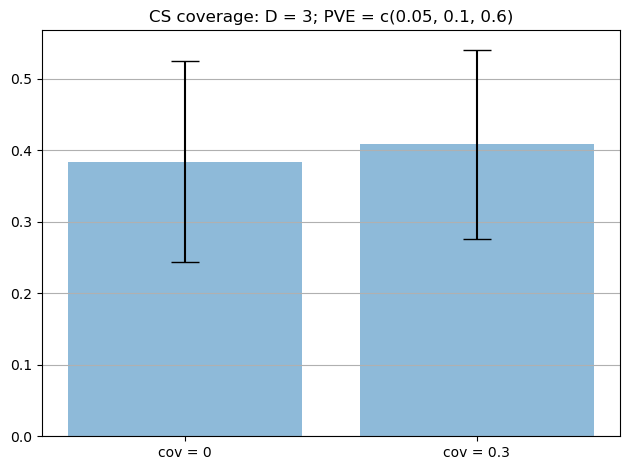

In [40]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)

ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('CS coverage: D = 3; PVE = c(0.05, 0.1, 0.6)')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()